# पीटर आणि लांडगा: पुनर्बलन शिक्षणाचा आरंभिक परिचय

या ट्यूटोरियलमध्ये, आपण मार्ग शोधण्याच्या समस्येवर पुनर्बलन शिक्षण कसे लागू करायचे ते शिकणार आहोत. ही परिस्थिती रशियन संगीतकार [सर्गेई प्रोकोफिएव्ह](https://en.wikipedia.org/wiki/Sergei_Prokofiev) यांच्या [पीटर आणि लांडगा](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) या संगीत परीकथेतून प्रेरित आहे. ही कथा तरुण पायोनियर पीटरची आहे, जो धाडसाने आपल्या घरातून बाहेर पडतो आणि लांडग्याचा पाठलाग करण्यासाठी जंगलातील मोकळ्या जागेकडे जातो. आपण मशीन लर्निंग अल्गोरिदम तयार करू, जे पीटरला परिसराचा शोध घेण्यास आणि एक आदर्श नेव्हिगेशन नकाशा तयार करण्यास मदत करतील.

सुरुवातीला, काही उपयुक्त लायब्ररी आयात करूया:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## पुनरावलोकन: रिइन्फोर्समेंट लर्निंग

**रिइन्फोर्समेंट लर्निंग** (RL) ही एक शिकण्याची तंत्र आहे जी आपल्याला **एजंट** च्या **पर्यावरणात** अनेक प्रयोग चालवून त्याचे सर्वोत्तम वर्तन शिकण्याची परवानगी देते. या पर्यावरणातील एजंटकडे काही **ध्येय** असले पाहिजे, जे **रिवॉर्ड फंक्शन** ने परिभाषित केलेले असते.

## पर्यावरण

सोपेपणासाठी, आपण पीटरच्या जगाला `width` x `height` आकाराच्या चौकोनी फळकुटासारखे मानू. या फळकुटातील प्रत्येक सेल खालीलपैकी एक असू शकतो:
* **जमीन**, ज्यावर पीटर आणि इतर प्राणी चालू शकतात
* **पाणी**, ज्यावर तुम्ही स्पष्टपणे चालू शकत नाही
* **झाड** किंवा **गवत** - जिथे तुम्ही थोडा आराम करू शकता
* **सफरचंद**, जे पीटरला स्वतःला खायला सापडल्यास आनंद होईल
* **लांडगा**, जो धोकादायक आहे आणि त्याला टाळले पाहिजे

या पर्यावरणासोबत काम करण्यासाठी, आपण `Board` नावाची एक वर्ग (class) परिभाषित करू. या नोटबुकमध्ये खूप गोंधळ होऊ नये म्हणून, बोर्डासोबत काम करण्यासाठी लागणारा सर्व कोड स्वतंत्र `rlboard` मॉड्यूलमध्ये हलवला आहे, जो आपण आता आयात करू. या मॉड्यूलच्या आत डोकावून, अंमलबजावणीच्या अंतर्गत तपशीलांबद्दल अधिक माहिती मिळवू शकता.


In [2]:
from rlboard import *

आता एक यादृच्छिक बोर्ड तयार करूया आणि तो कसा दिसतो ते पाहूया:


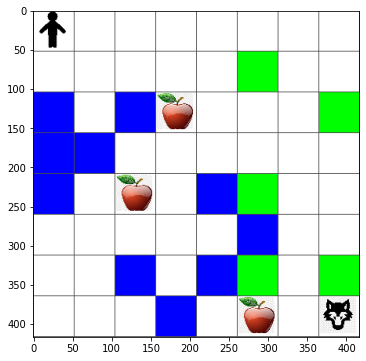

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## क्रिया आणि धोरण

आपल्या उदाहरणात, पीटरचा उद्देश सफरचंद शोधणे आहे, तर लांडगा आणि इतर अडथळ्यांपासून दूर राहणे आहे. हे करण्यासाठी, तो सफरचंद सापडेपर्यंत फिरू शकतो. त्यामुळे, कोणत्याही स्थानावर तो खालीलपैकी एक क्रिया निवडू शकतो: वर, खाली, डावीकडे आणि उजवीकडे. आपण या क्रियांना एक शब्दकोश म्हणून परिभाषित करू आणि त्यांना संबंधित समन्वय बदलांच्या जोड्यांशी नकाशित करू. उदाहरणार्थ, उजवीकडे (`R`) जाणे `(1,0)` या जोड्येशी संबंधित असेल.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

आपल्या एजंट (पीटर) ची रणनीती तथाकथित **धोरण** द्वारे परिभाषित केली जाते. चला सर्वात सोप्या धोरणाचा विचार करू, ज्याला **रँडम वॉक** म्हणतात.

## रँडम वॉक

चला प्रथम रँडम वॉक रणनीती अंमलात आणून आपली समस्या सोडवूया.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

चला रँडम वॉक प्रयोग अनेक वेळा चालवूया आणि घेतलेल्या सरासरी पावलांची संख्या पाहूया:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## बक्षीस फंक्शन

आपली धोरण अधिक बुद्धिमान बनवण्यासाठी, आपल्याला समजून घ्यावे लागेल की कोणते हालचाली इतरांपेक्षा "चांगल्या" आहेत.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## क्यू-लर्निंग

क्यू-टेबल किंवा बहुआयामी अॅरे तयार करा. आपला बोर्ड `width` x `height` या परिमाणांचा असल्यामुळे, आपण क्यू-टेबलला `width` x `height` x `len(actions)` या आकाराच्या numpy अॅरेद्वारे दर्शवू शकतो:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-टेबल बोर्डवर टेबल दर्शविण्यासाठी प्लॉट फंक्शनला पास करा:


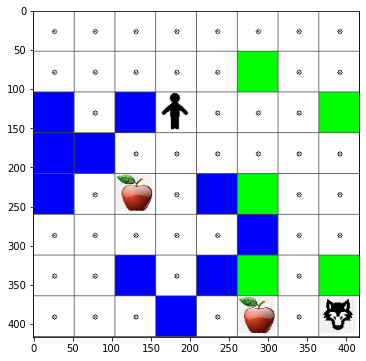

In [9]:
m.plot(Q)

## Q-Learning चा सार: बेलमन समीकरण आणि शिक्षण अल्गोरिदम

आपल्या शिक्षण अल्गोरिदमसाठी एक छद्म-कोड लिहा:

* सर्व स्थिती आणि क्रियांसाठी समान संख्यांसह Q-टेबल Q प्रारंभ करा
* शिक्षण दर $\alpha\leftarrow 1$ सेट करा
* अनेक वेळा अनुकरण पुन्हा करा
   1. यादृच्छिक स्थानावर प्रारंभ करा
   1. पुन्हा करा
        1. स्थिती $s$ वर क्रिया $a$ निवडा
        2. नवीन स्थिती $s'$ वर हलवून क्रिया अंमलात आणा
        3. जर गेम संपण्याची अट पूर्ण झाली, किंवा एकूण बक्षीस खूप कमी असेल - अनुकरणातून बाहेर पडा  
        4. नवीन स्थितीवर बक्षीस $r$ गणना करा
        5. बेलमन समीकरणानुसार Q-फंक्शन अद्यतनित करा: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. एकूण बक्षीस अद्यतनित करा आणि $\alpha$ कमी करा.

## शोषण विरुद्ध अन्वेषण

सर्वोत्तम दृष्टिकोन म्हणजे अन्वेषण आणि शोषण यामध्ये संतुलन राखणे. आपण आपल्या वातावरणाबद्दल अधिक शिकत असताना, आम्ही अधिक प्रमाणात सर्वोत्तम मार्ग अनुसरण करू, परंतु कधीकधी न शोधलेल्या मार्गाचा पर्याय निवडणे योग्य ठरेल.

## Python अंमलबजावणी

आता आपण शिक्षण अल्गोरिदम अंमलात आणण्यासाठी तयार आहोत. त्याआधी, आपल्याला एक फंक्शन देखील आवश्यक आहे जे Q-टेबलमधील मनमानी संख्यांना संबंधित क्रियांसाठी संभाव्यतेच्या व्हेक्टरमध्ये रूपांतरित करेल:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

आम्ही मूळ व्हेक्टरमध्ये `eps` ची थोडीशी मात्रा जोडतो जेणेकरून प्रारंभिक स्थितीत, जेव्हा व्हेक्टरचे सर्व घटक समान असतात, शून्याने भागण्याची समस्या टाळता येईल.

खरा शिक्षण अल्गोरिदम आम्ही 5000 प्रयोगांसाठी चालवणार आहोत, ज्याला **epochs** असेही म्हणतात:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

अल्गोरिदम कार्यान्वित केल्यानंतर, Q-टेबलमध्ये प्रत्येक टप्प्यावर विविध कृतींच्या आकर्षकतेची व्याख्या करणाऱ्या मूल्यांसह अद्यतनित केले पाहिजे. येथे टेबल दृश्यात दाखवा:


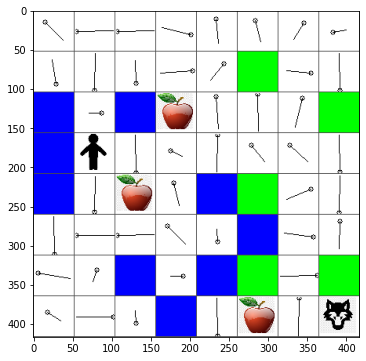

In [12]:
m.plot(Q)

## धोरण तपासणे

Q-Table प्रत्येक स्थितीतील प्रत्येक क्रियेच्या "आकर्षकतेची" यादी देते, त्यामुळे आपल्या जगात कार्यक्षम नेव्हिगेशन परिभाषित करण्यासाठी याचा वापर करणे खूप सोपे आहे. सर्वात सोप्या प्रकरणात, आपण फक्त Q-Table मधील सर्वाधिक मूल्याशी संबंधित क्रिया निवडू शकतो:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

जर तुम्ही वरील कोड अनेक वेळा चालवून पाहिलात, तर तुम्हाला कदाचित लक्षात येईल की कधी कधी तो फक्त "थांबतो", आणि तुम्हाला नोटबुकमधील STOP बटण दाबून तो थांबवावा लागतो.

> **कार्य 1:** `walk` फंक्शनमध्ये बदल करून पथाची जास्तीत जास्त लांबी ठराविक पायऱ्यांमध्ये (उदा. 100) मर्यादित करा, आणि वरील कोड कधीकधी ही किंमत परत देताना पाहा.

> **कार्य 2:** `walk` फंक्शनमध्ये बदल करून असे सुनिश्चित करा की ते आधीच भेट दिलेल्या ठिकाणी पुन्हा जाऊ शकत नाही. यामुळे `walk` लूप होण्यापासून रोखले जाईल, परंतु एजंट अजूनही अशा ठिकाणी "अडकू" शकतो जिथून तो बाहेर पडू शकत नाही.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


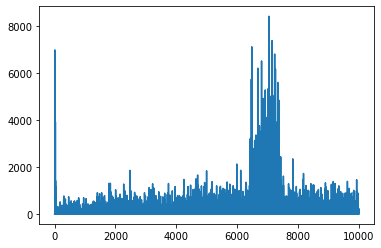

In [15]:
plt.plot(lpath)

जेव्हा आपण पाहतो की सुरुवातीला सरासरी मार्गाची लांबी वाढली आहे. याचे कारण असे असू शकते की जेव्हा आपल्याला वातावरणाबद्दल काहीही माहिती नसते - तेव्हा आपण खराब स्थितीत, पाण्यात किंवा लांडग्याच्या जाळ्यात अडकण्याची शक्यता असते. जसजसे आपण अधिक शिकतो आणि ही माहिती वापरायला सुरुवात करतो, तसतसे आपण वातावरणाचा अधिक वेळासाठी शोध घेऊ शकतो, परंतु तरीही आपल्याला सफरचंद कुठे आहेत हे चांगल्या प्रकारे माहित नसते.

जेव्हा आपण पुरेसे शिकतो, तेव्हा एजंटसाठी उद्दिष्ट साध्य करणे सोपे होते आणि मार्गाची लांबी कमी होऊ लागते. तथापि, आपण अजूनही शोध घेण्यास मोकळे असतो, त्यामुळे आपण अनेकदा सर्वोत्तम मार्गापासून दूर जातो आणि नवीन पर्यायांचा शोध घेतो, ज्यामुळे मार्ग अपेक्षेपेक्षा लांब होतो.

आपण या ग्राफवर आणखी एक गोष्ट पाहतो, ती म्हणजे काही वेळानंतर लांबी अचानक वाढली. याचा अर्थ प्रक्रियेचा स्टोकेस्टिक (अनिश्चित) स्वभाव आहे, आणि कधीकधी आपण Q-Table गुणांक खराब करू शकतो, त्यांना नवीन मूल्यांनी अधिलिखित करून. हे आदर्शतः शिकण्याचा दर कमी करून (उदा. प्रशिक्षणाच्या शेवटी आपण Q-Table मूल्ये फक्त थोड्या प्रमाणात समायोजित करतो) कमी केले पाहिजे.

एकूणच, हे लक्षात ठेवणे महत्त्वाचे आहे की शिकण्याच्या प्रक्रियेचा यश आणि गुणवत्ता मोठ्या प्रमाणात अशा पॅरामीटर्सवर अवलंबून असते, जसे की शिकण्याचा दर, शिकण्याचा दर कमी होणे आणि डिस्काउंट फॅक्टर. यांना **हायपरपॅरामीटर्स** म्हणतात, जे प्रशिक्षणादरम्यान आपण ऑप्टिमाइझ करतो अशा **पॅरामीटर्स** पासून वेगळे असतात (उदा. Q-Table गुणांक). सर्वोत्तम हायपरपॅरामीटर मूल्ये शोधण्याच्या प्रक्रियेला **हायपरपॅरामीटर ऑप्टिमायझेशन** म्हणतात, आणि यासाठी स्वतंत्र विषय आवश्यक आहे.


## व्यायाम
#### एक अधिक वास्तववादी पीटर आणि वुल्फ जग

आपल्या परिस्थितीत, पीटर जवळजवळ थकलेला किंवा भुकेला न होता फिरू शकत होता. अधिक वास्तववादी जगात, त्याला वेळोवेळी बसून विश्रांती घ्यावी लागते आणि स्वतःला अन्न द्यावे लागते. खालील नियम लागू करून आपले जग अधिक वास्तववादी बनवूया:

1. एका ठिकाणाहून दुसऱ्या ठिकाणी जाण्याने पीटरची **ऊर्जा** कमी होते आणि त्याला **थकवा** येतो.
2. सफरचंद खाल्ल्याने पीटर अधिक ऊर्जा मिळवू शकतो.
3. झाडाखाली किंवा गवतावर विश्रांती घेऊन (उदा. झाड किंवा गवत असलेल्या बोर्डच्या ठिकाणी चालत जाणे - हिरव्या क्षेत्रात) पीटर थकवा दूर करू शकतो.
4. पीटरला वुल्फ शोधून त्याला मारावे लागते.
5. वुल्फला मारण्यासाठी, पीटरकडे विशिष्ट पातळीची ऊर्जा आणि थकवा असणे आवश्यक आहे, अन्यथा तो लढाई हरतो.

वर दिलेल्या बक्षीस फंक्शनमध्ये खेळाच्या नियमांनुसार बदल करा, reinforcement learning algorithm चालवा जेणेकरून खेळ जिंकण्यासाठी सर्वोत्तम रणनीती शिकता येईल, आणि random walk च्या निकालांची तुमच्या algorithm सोबत तुलना करा जिंकलेल्या आणि हरलेल्या खेळांच्या संख्येच्या दृष्टीने.

> **Note**: तुम्हाला hyperparameters समायोजित करावे लागतील जेणेकरून ते कार्य करेल, विशेषतः epochs ची संख्या. कारण खेळाचा यश (वुल्फशी लढणे) हा दुर्मिळ घटना आहे, तुम्हाला खूप जास्त प्रशिक्षण वेळ अपेक्षित असू शकतो.



---

**अस्वीकरण**:  
हा दस्तऐवज AI भाषांतर सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) चा वापर करून भाषांतरित करण्यात आला आहे. आम्ही अचूकतेसाठी प्रयत्नशील असलो तरी कृपया लक्षात घ्या की स्वयंचलित भाषांतरांमध्ये त्रुटी किंवा अचूकतेचा अभाव असू शकतो. मूळ भाषेतील दस्तऐवज हा अधिकृत स्रोत मानला जावा. महत्त्वाच्या माहितीसाठी व्यावसायिक मानवी भाषांतराची शिफारस केली जाते. या भाषांतराचा वापर केल्यामुळे उद्भवणाऱ्या कोणत्याही गैरसमज किंवा चुकीच्या अर्थासाठी आम्ही जबाबदार राहणार नाही.
